В этом notebook мы будем работать над улучшением метрик бейслайн моделей, путем дополнительных преобразований с данными. Существует 2 подхода:

1. Тестировать каждое преобразование отдельно и сравнивать с бейслайном, затем выбрать только лучшие и скомбинировать их

2. Поочередно применять удачные преобразования, сравнивая результат каждого нового преобразования с результатом предыдущего (итеративный подход)

Здесь мы будем использовать первый подход, так как он менее трудозатратный и более интерпретируемый и не важно в каком порядке вносим фичи.

1. ПРЕДОБРАБОТКА

In [ ]:
from help import *
from plot import * 
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

SEED = 52 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

import warnings

warnings.filterwarnings("ignore")

In [64]:
df = pd.read_csv('boston.csv')

In [ ]:
X, y = divide_data(df, 'MEDV')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED) 

In [82]:
numerical_cols = X.columns.drop('CHAS')
categorical_cols = ['CHAS']

In [ ]:
# уже знакомый нам пайплайн
preprocessor = Pipeline([
    ('identity', FunctionTransformer())
])
preprocessor.set_output(transform="pandas")

Pipeline(steps=[('identity', FunctionTransformer())])

In [68]:
# сохраним все бейслайн модели в виде списка для удобства
models = [
    ('LinearRegression', LinearRegression()),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=SEED, max_depth=4)),
    ('RandomForestRegressor', RandomForestRegressor(random_state=SEED)),
    ('XGBRegressor', XGBRegressor(random_state=SEED))
]

In [ ]:
#Инициализируем кросс-валидацию с перемешиванием (не временные данные) и 5-ю фолдами
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

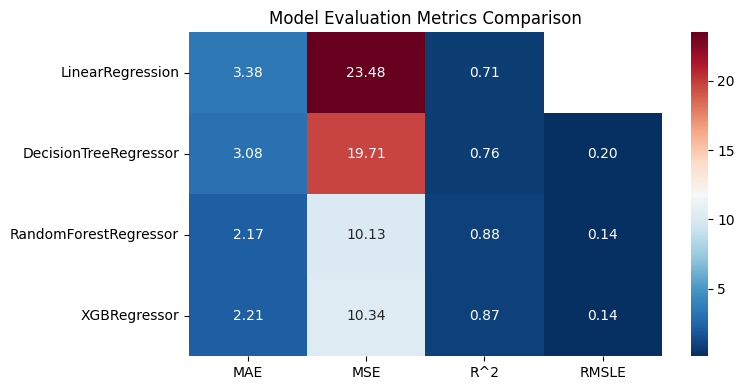

In [70]:
initial_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

2. ПРЕОБРАЗОВАНИЕ ДАННЫХ И FEATURE ENGINEERING

2.1 Некоторые признаки с ассиметричным распределением, которые можно cгладить логарифмированием.

2.1.1 Без удаления столбцов

In [71]:
X_log = X.copy()

In [72]:
#В baseline.ipynb мы уже выяснили, что CRIM, ZN и B имеют больше всего выбросов на boxplot и тяжелые хвосты. Преобразуем их
X_log['CRIMlog'] = np.log1p(X['CRIM'])
X_log['ZNlog'] = np.log1p(X['ZN'])
X_log['Blog'] = np.log1p(X['B'])

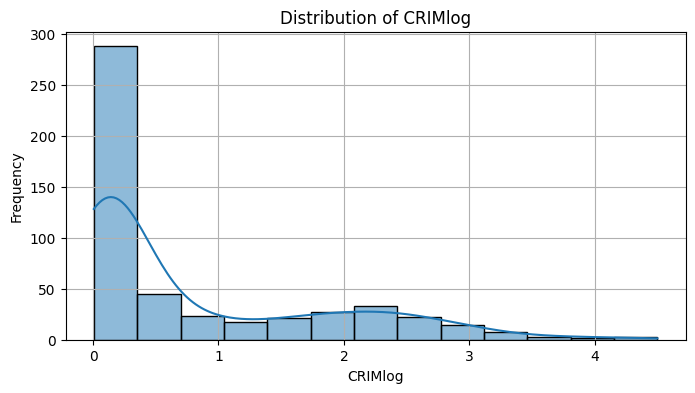

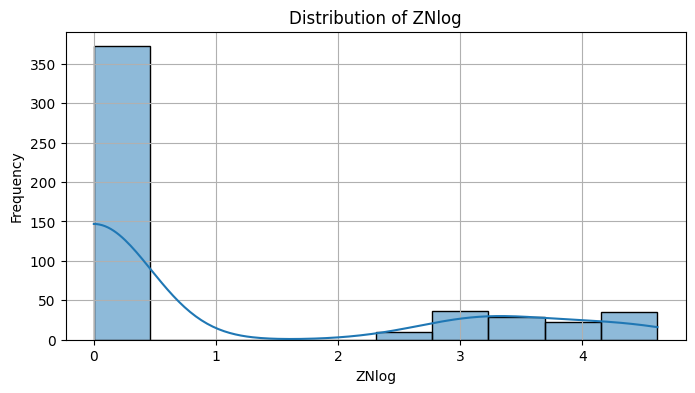

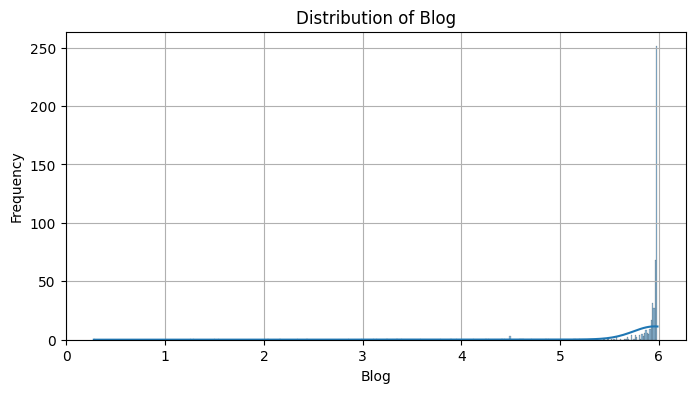

In [73]:
#Посмотрим как сжались графики -- нормальным распределение не стало, но прилично сократился масштаб.
for col in ['CRIMlog', 'ZNlog', 'Blog']:
    plot_hist_numeric(X_log, col)

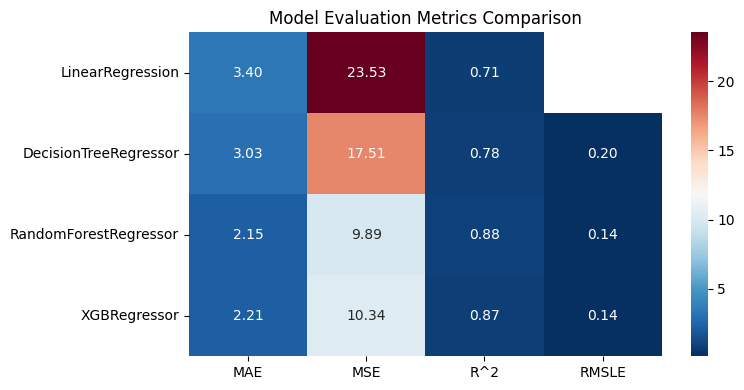

In [74]:
#Оценим результаты преобразований
log_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                             MAE       MSE       R^2     RMSLE
 LinearRegression       0.021735  0.043523 -0.000625       NaN
 DecisionTreeRegressor -0.050174 -2.201643  0.020630 -0.004688
 RandomForestRegressor -0.019160 -0.240928  0.002228 -0.000748
 XGBRegressor           0.000000  0.000000  0.000000  0.000000)

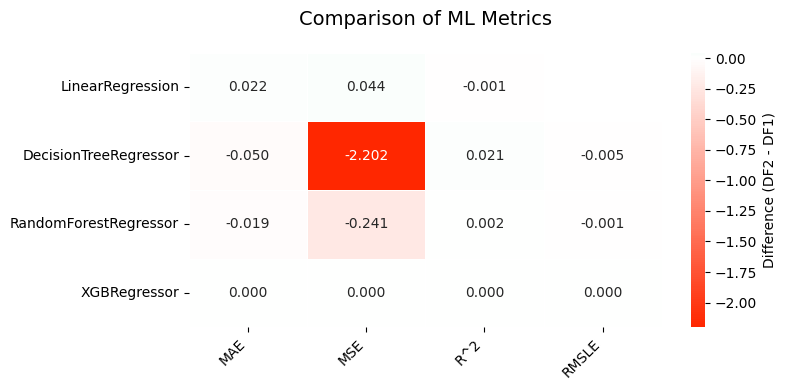

In [243]:
# сравним изначальные метрики с метриками после логарифмирования и выведем график
compare_metrics_heatmap(initial_metrics, log_metrics)

Как видно, это немного улучшило результаты для решающего дерева и чуть-чуть для случайного леса.

2.1.2 С удалением исходных столбцов

In [244]:
X_log_delete = X_log.drop(columns = ['CRIM', 'ZN', 'B'])


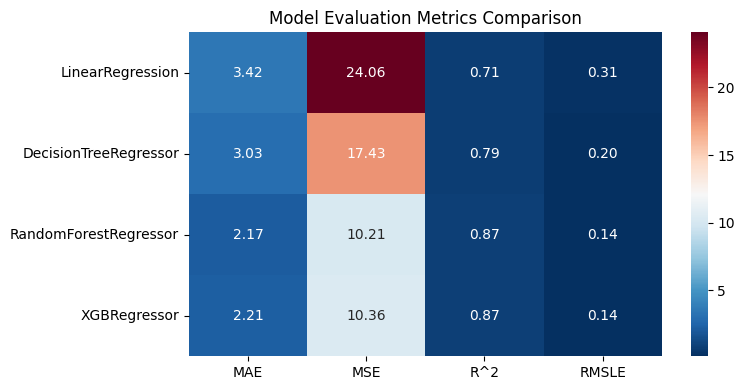

In [245]:
log_delete_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log_delete,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                             MAE       MSE       R^2     RMSLE
 LinearRegression       0.043532  0.577565 -0.006942       NaN
 DecisionTreeRegressor -0.051087 -2.273401  0.021677 -0.007449
 RandomForestRegressor -0.003313  0.071291 -0.000941 -0.000095
 XGBRegressor           0.002384  0.017438  0.000412 -0.000495)

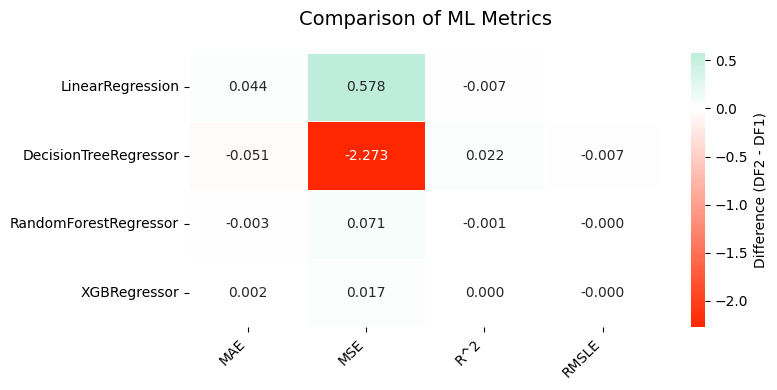

In [246]:
compare_metrics_heatmap(initial_metrics, log_delete_metrics)

Стало даже хуже.

2.2 Добавление взаимодействия признаков -- PolyFeatures.

In [377]:
# Создаем полиномиальные признаки для числовых
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly_cols = X.columns.drop('CHAS')
poly_features = poly.fit_transform(X[numerical_cols])

# Получаем имена новых признаков
poly_feature_names = poly.get_feature_names_out(numerical_cols)

# Создаем DataFrame с полиномиальными признаками
X_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

# Добавляем бинарный признак без изменений 
X_poly[categorical_cols] = df[categorical_cols]
len(X_poly.columns), len(numerical_cols)

(91, 12)

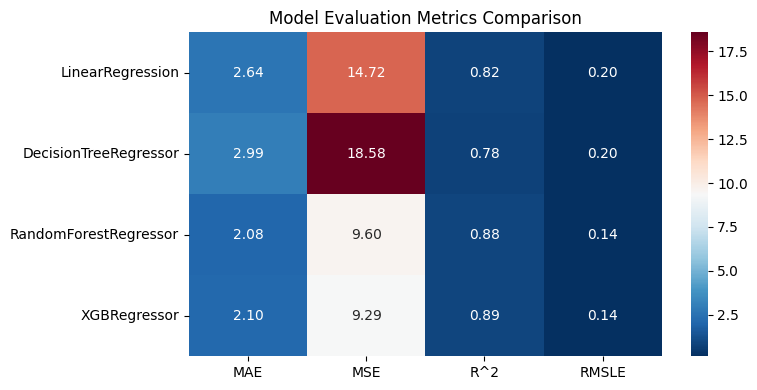

In [ ]:
poly_metrics = train_evaluate_models_cv(
    models=models,
    X=X_poly,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                             MAE       MSE       R^2     RMSLE
 LinearRegression      -0.741244 -8.760706  0.104186       NaN
 DecisionTreeRegressor -0.087118 -1.128182  0.010881 -0.005683
 RandomForestRegressor -0.092565 -0.533266  0.005776 -0.002369
 XGBRegressor          -0.108381 -1.055744  0.015765 -0.005582)

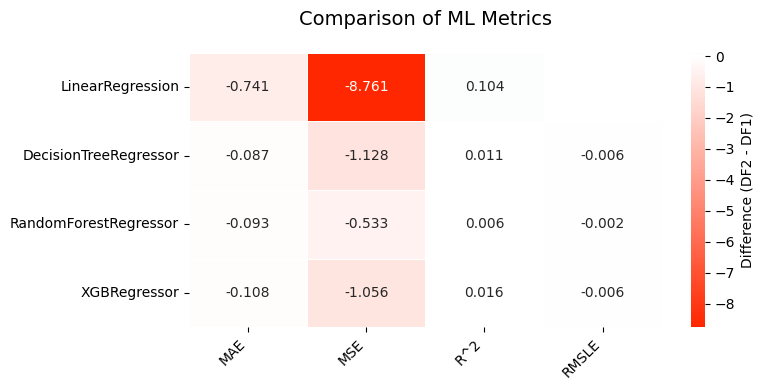

In [379]:
compare_metrics_heatmap(initial_metrics, poly_metrics)

Как видим, это хорошо улучшило точность бустинга и немного случайного леса, но по времени модель работает заметно дольше в пару раз. Благо, датасет небольшой.

2.3 ОГРАНИЧЕНИЕ ВЫБРОСОВ.

Попробуем в признаках с огромными хвостами обрезать значения по квантилям (например, 5-95%). Возьмем те же, что и в прошлый раз.

In [127]:
X_no_outliers = X.copy()

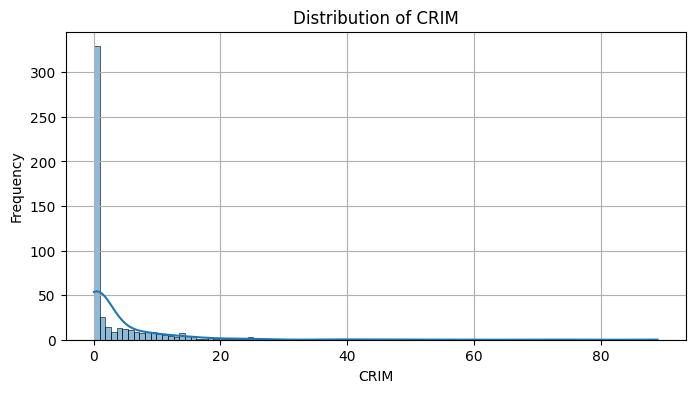

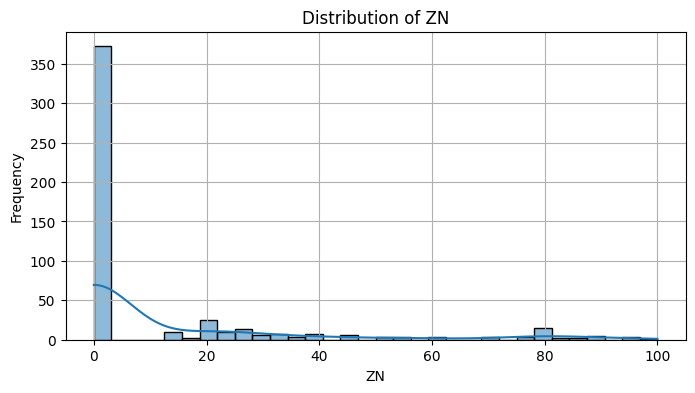

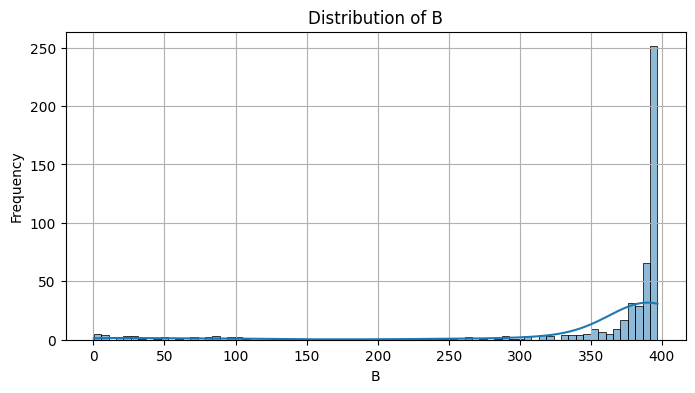

In [102]:
#Посмотрим еще раз на признаки с тяжелыми хвостами
for col in ['CRIM', 'ZN', 'B']:
    plot_hist_numeric(df, col)

In [124]:
#Посмотрим какие границы сохраняют большую часть признаков
np.quantile(df['CRIM'], 0.95), np.quantile(df['ZN'], 0.95), np.quantile(df['B'], 0.1)

(np.float64(15.78915), np.float64(80.0), np.float64(290.27))

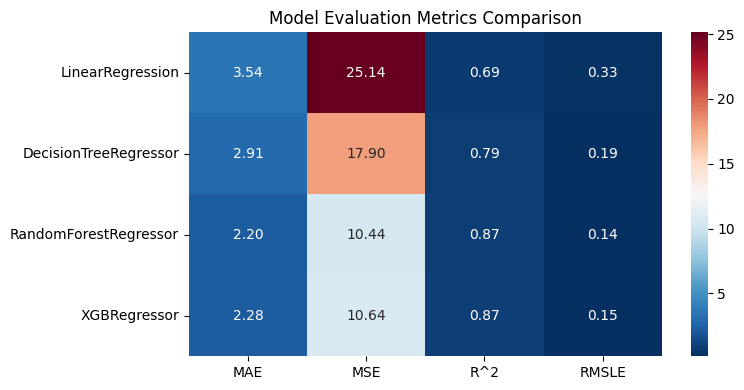

(<Figure size 800x400 with 2 Axes>,
                             MAE       MSE       R^2     RMSLE
 LinearRegression       0.159149  1.655946 -0.020124       NaN
 DecisionTreeRegressor -0.169219 -1.808929  0.022922 -0.016866
 RandomForestRegressor  0.023228  0.306359 -0.003278  0.003878
 XGBRegressor           0.071261  0.294704 -0.001975  0.004167)

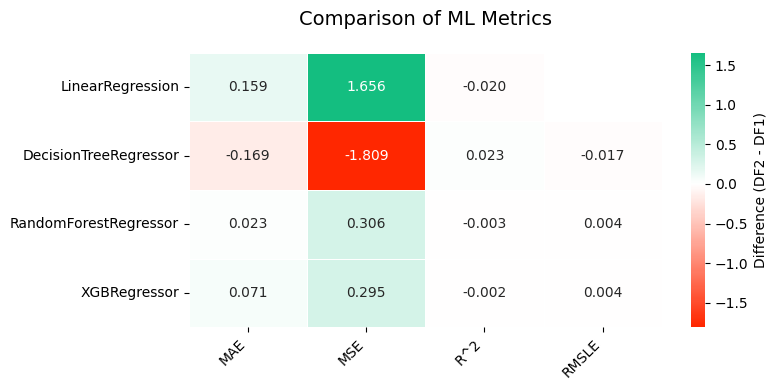

In [134]:
#В последнем случае обрежем левые 10% выбросов и масштаб станет уже 291-400
X_no_outliers = winsorize_outliers(X_no_outliers, 'CRIM', upper_bound = np.quantile(df['CRIM'], 0.9))
X_no_outliers = winsorize_outliers(X_no_outliers, 'ZN', upper_bound = np.quantile(df['ZN'], 0.9))
X_no_outliers = winsorize_outliers(X_no_outliers, 'B', lower_bound = np.quantile(df['B'], 0.1))

no_outliers_metrics = train_evaluate_models_cv(
    models = models, 
    X = X_no_outliers, 
    y = y, 
    preprocessor = preprocessor, 
    cv = cv, 
    seed = SEED
)
compare_metrics_heatmap(initial_metrics, no_outliers_metrics)

Как видим, это немного помогло одному решающему дереву (возможно, меньше переобучается, но в случайном лесу и бустинге только ухудшило результаты)

2.4 Первичный отбор признаков -- SelectKBestFeatures и MutualInfoRegression

In [136]:
X_selected = X.copy()

In [168]:
  t=20
  scores = mutual_info_regression(X_poly, y)

    # Toп i признаков
  top_i_idx = np.argsort(scores)[::-1][:t]
  top_i_features = X_poly.columns[top_i_idx]
  top_i_features

Index(['TAX LSTAT', 'PTRATIO LSTAT', 'LSTAT', 'LSTAT^2', 'NOX LSTAT',
       'INDUS LSTAT', 'RM LSTAT', 'B LSTAT', 'NOX PTRATIO', 'RM',
       'INDUS PTRATIO', 'RM^2', 'NOX TAX', 'AGE LSTAT', 'RM B', 'RAD LSTAT',
       'INDUS NOX', 'INDUS', 'NOX', 'PTRATIO'],
      dtype='object')

Кол-во признаков 12: Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


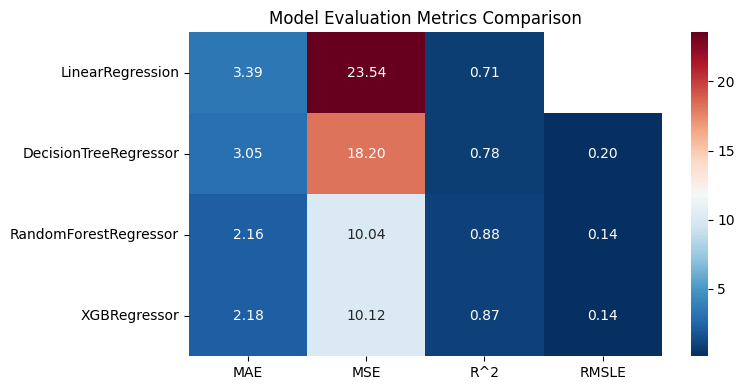

Кол-во признаков 11: Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],
      dtype='object')


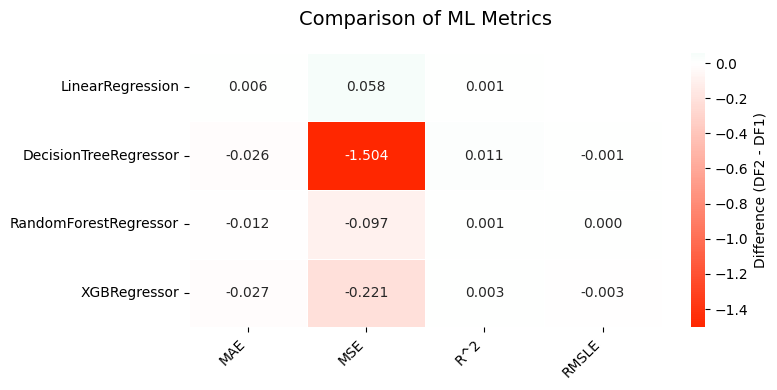

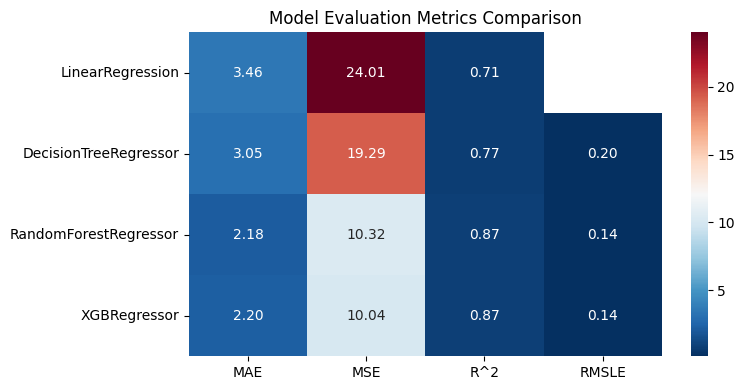

Кол-во признаков 10: Index(['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
       'LSTAT'],
      dtype='object')


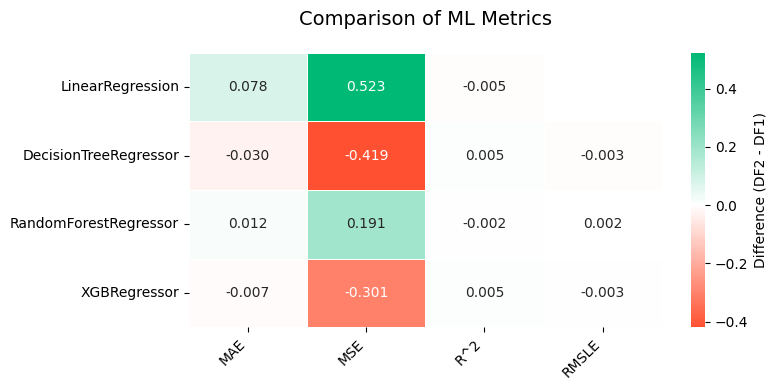

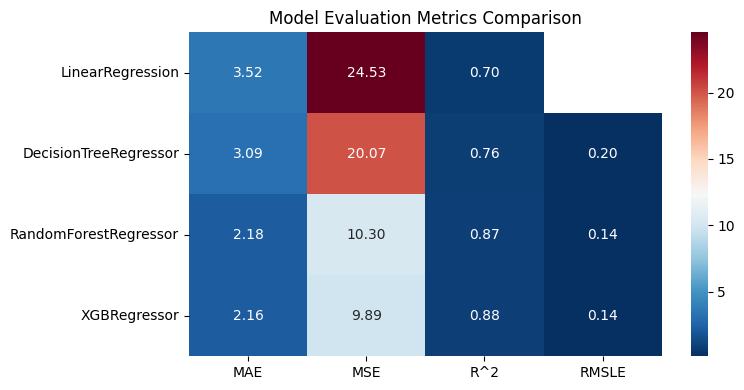

Кол-во признаков 9: Index(['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')


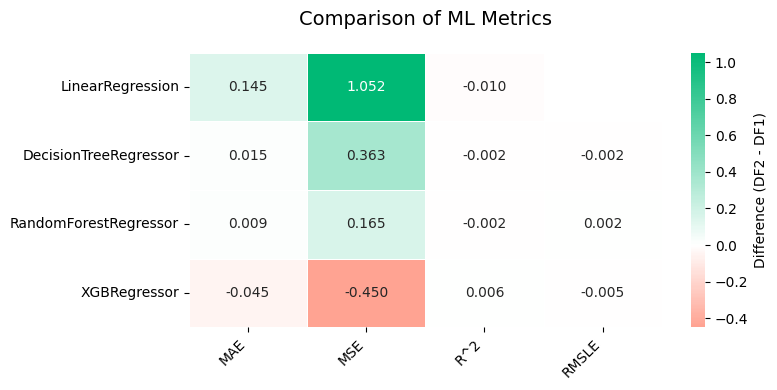

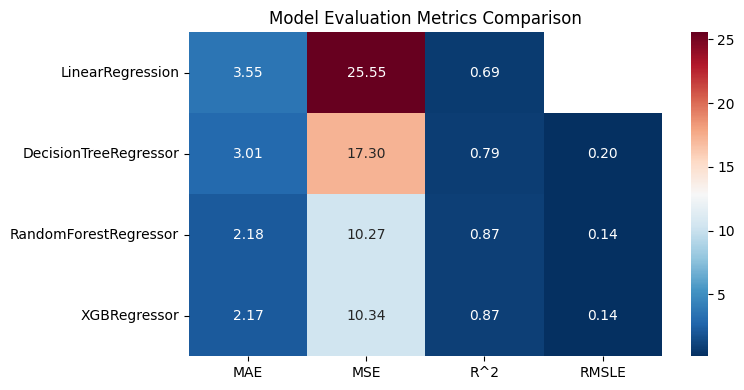

Кол-во признаков 8: Index(['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')


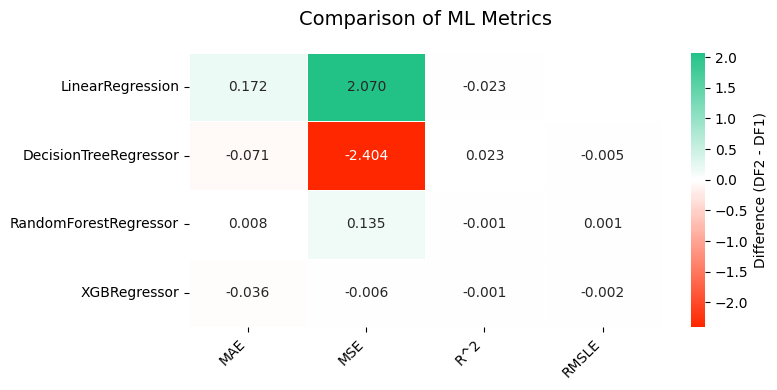

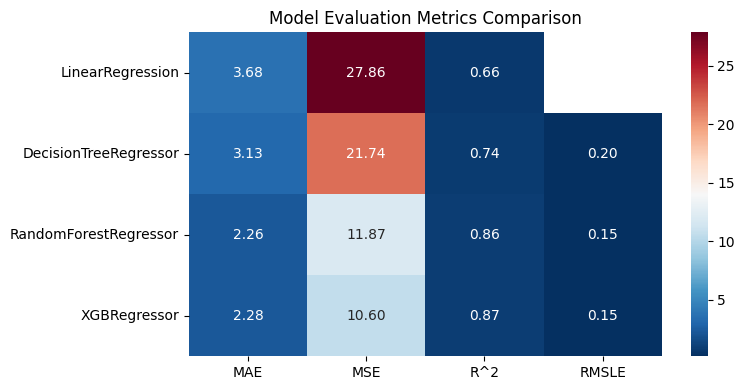

Кол-во признаков 7: Index(['CRIM', 'INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')


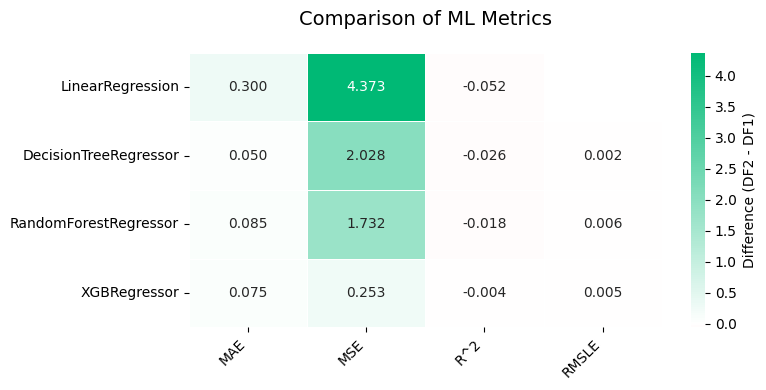

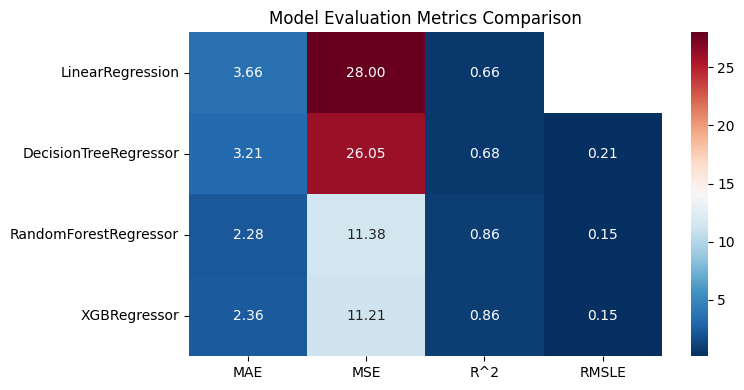

Кол-во признаков 6: Index(['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')


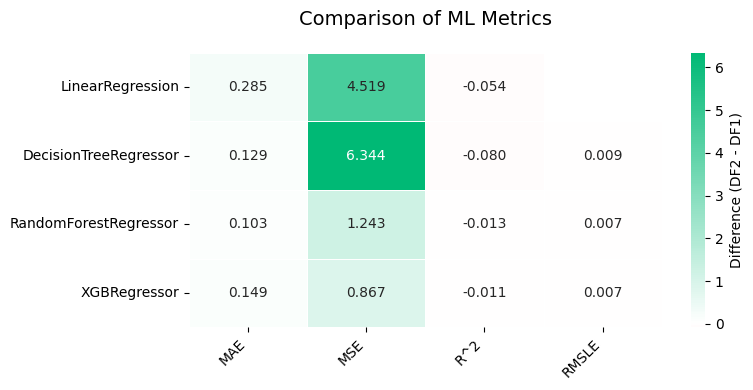

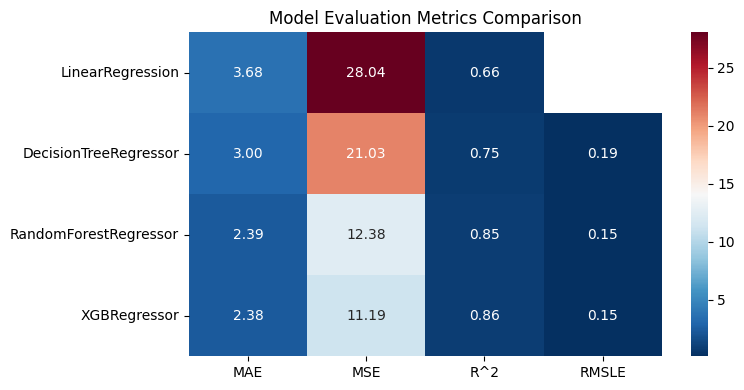

Кол-во признаков 5: Index(['INDUS', 'NOX', 'RM', 'PTRATIO', 'LSTAT'], dtype='object')


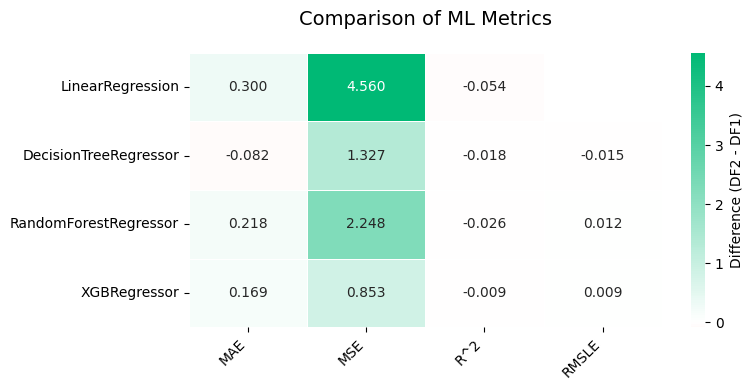

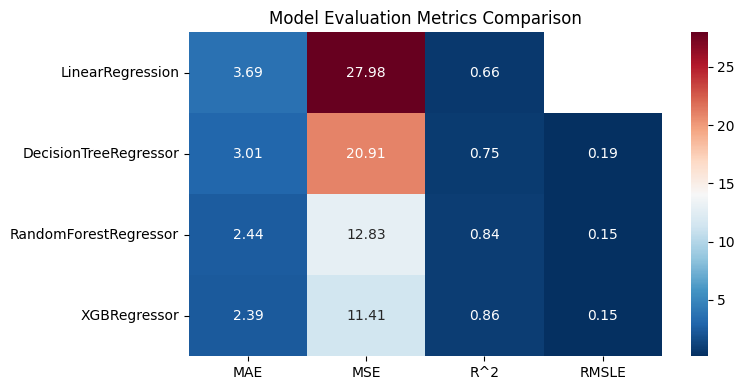

Кол-во признаков 4: Index(['INDUS', 'NOX', 'RM', 'LSTAT'], dtype='object')


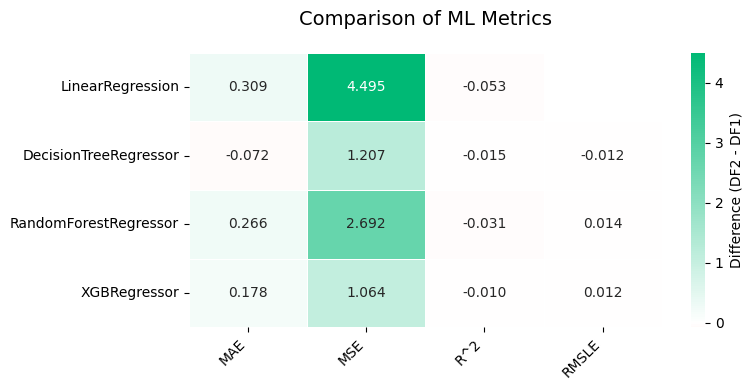

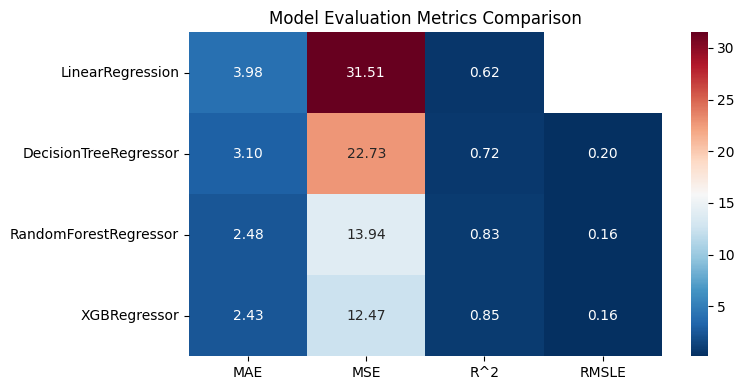

Кол-во признаков 3: Index(['INDUS', 'RM', 'LSTAT'], dtype='object')


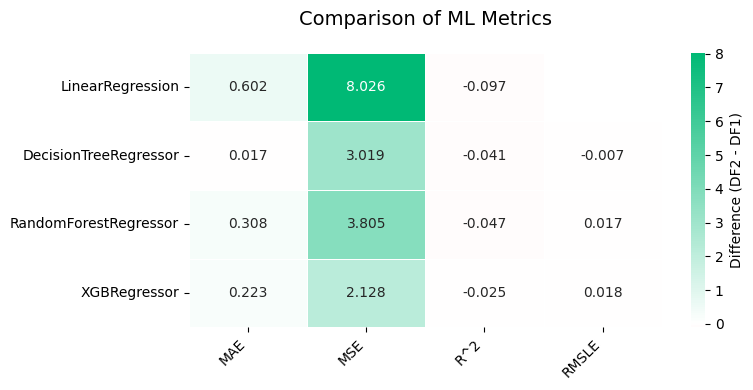

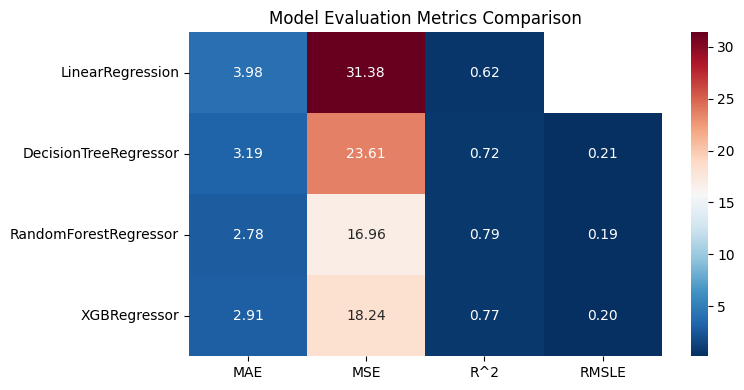

Кол-во признаков 2: Index(['RM', 'LSTAT'], dtype='object')


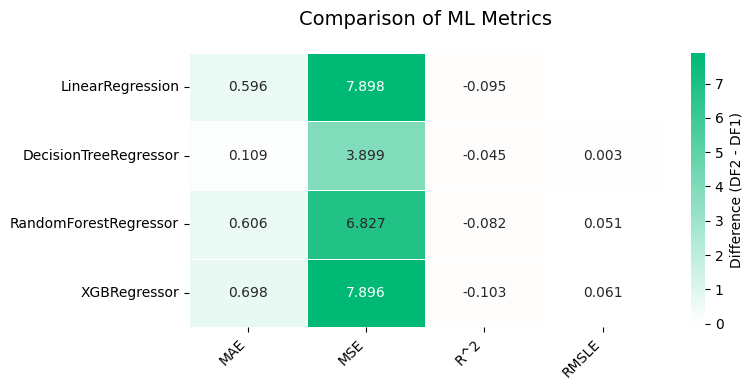

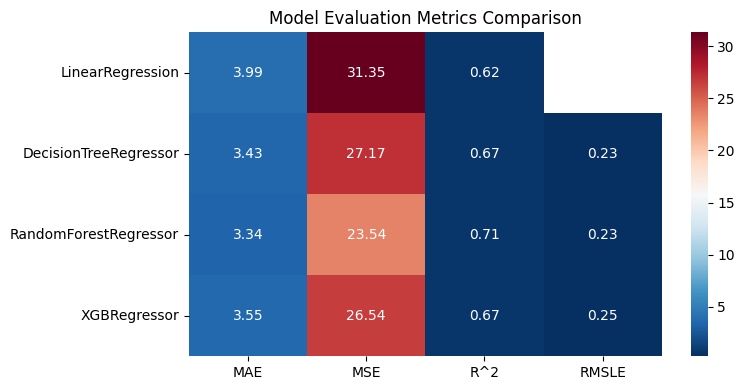

Кол-во признаков 1: Index(['LSTAT'], dtype='object')


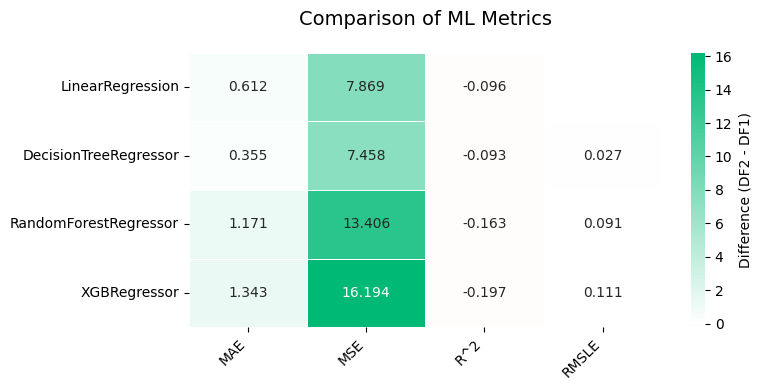

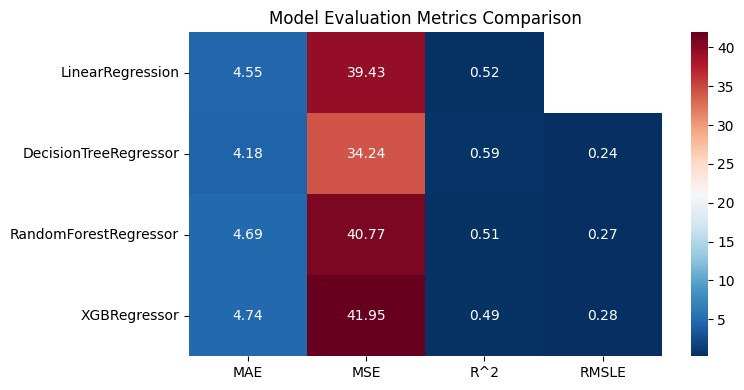

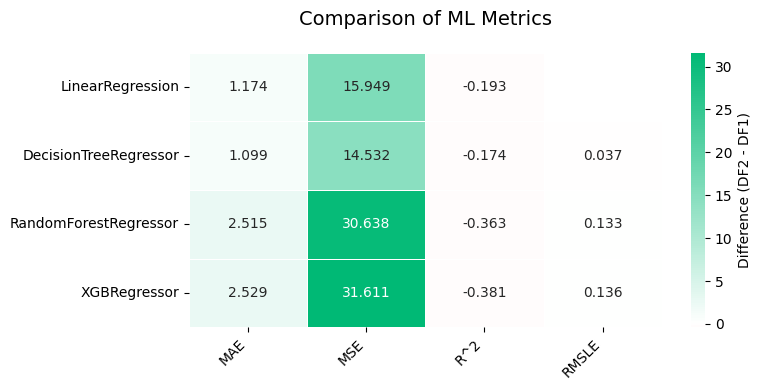

In [196]:
#Попробуем отбор с учетом линейности

for i in reversed(range(1,13)):
    scores = mutual_info_regression(X, y)

    selector = SelectKBest(score_func = mutual_info_regression, k = i)
    X_selected = pd.DataFrame(
    selector.fit_transform(X, y),
    columns=X.columns[selector.get_support()],
    index=X.index
)   
    print(f'Кол-во признаков {i}: {X_selected.columns}')  
    selected_metrics = train_evaluate_models_cv(
    models=models,
    X=X_selected,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED)
    compare_metrics_heatmap(initial_metrics, selected_metrics)



Как видим, выигрыш по метрикам незначительный или отрицательный. Попробуем отобрать c учетом нелинейных зависимостей.

Кол-во признаков 12: ['LSTAT' 'RM' 'NOX' 'INDUS' 'PTRATIO' 'TAX' 'CRIM' 'AGE' 'DIS' 'RAD' 'ZN'
 'B']


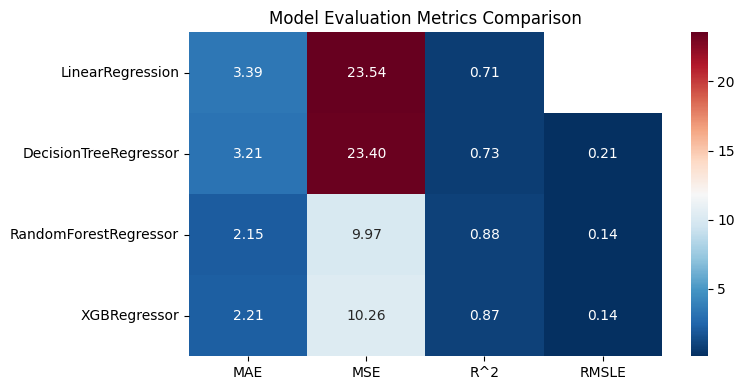

Кол-во признаков 11: ['LSTAT' 'RM' 'NOX' 'INDUS' 'PTRATIO' 'TAX' 'CRIM' 'AGE' 'DIS' 'RAD' 'ZN']


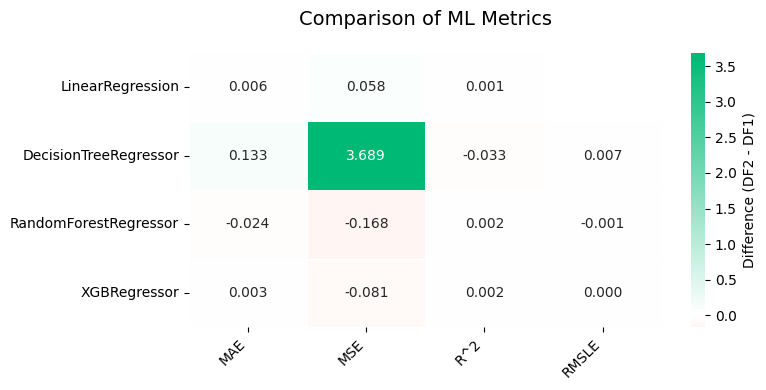

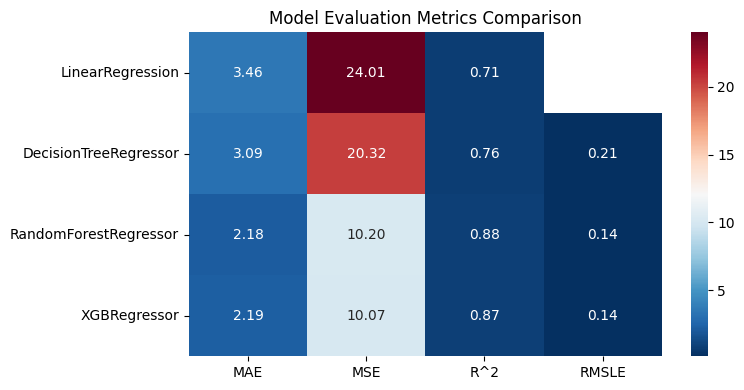

Кол-во признаков 10: ['LSTAT' 'RM' 'NOX' 'INDUS' 'PTRATIO' 'TAX' 'CRIM' 'AGE' 'DIS' 'RAD']


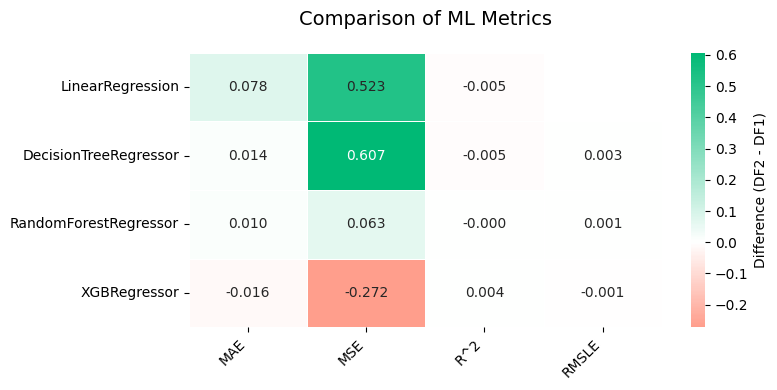

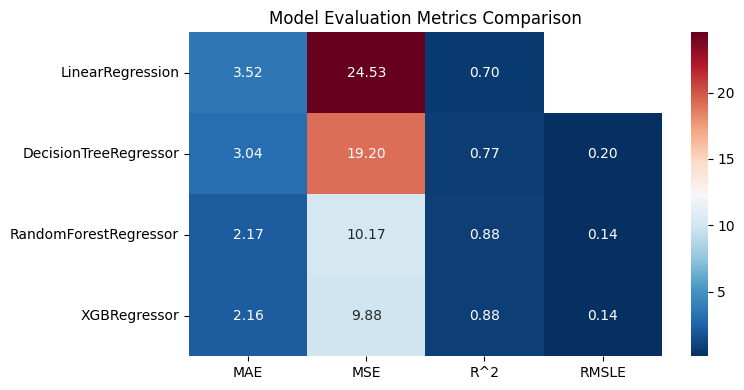

Кол-во признаков 9: ['LSTAT' 'RM' 'NOX' 'INDUS' 'PTRATIO' 'TAX' 'CRIM' 'AGE' 'DIS']


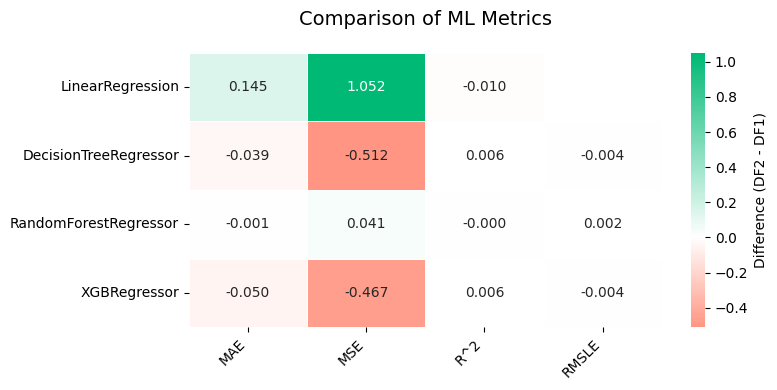

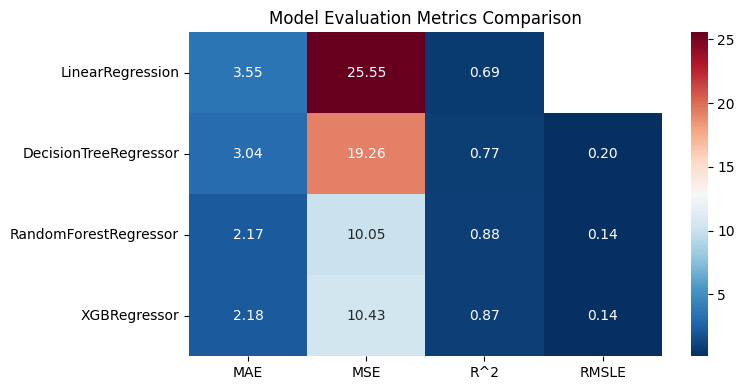

Кол-во признаков 8: ['LSTAT' 'RM' 'NOX' 'INDUS' 'PTRATIO' 'TAX' 'CRIM' 'AGE']


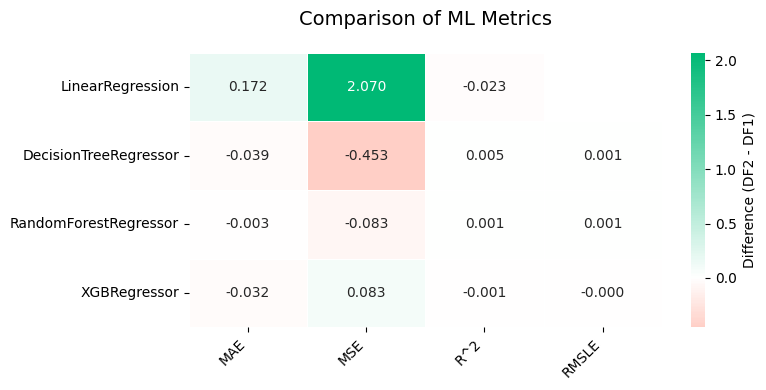

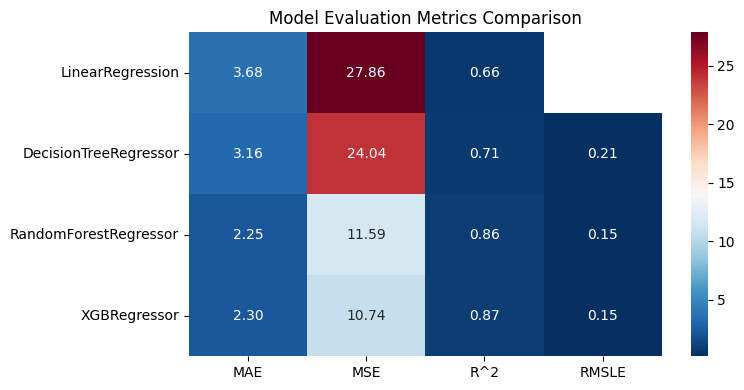

Кол-во признаков 7: ['LSTAT' 'RM' 'NOX' 'INDUS' 'PTRATIO' 'TAX' 'CRIM']


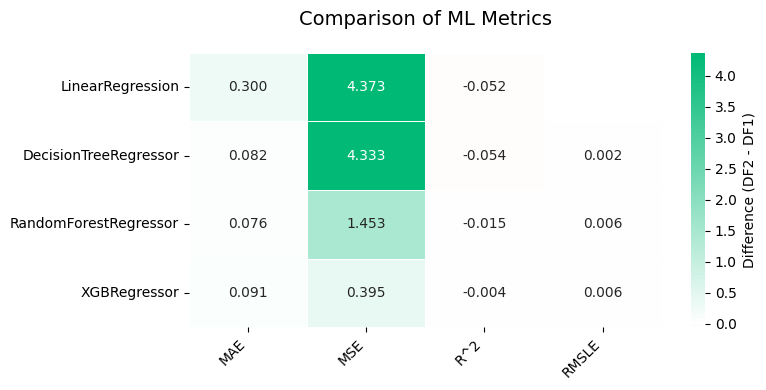

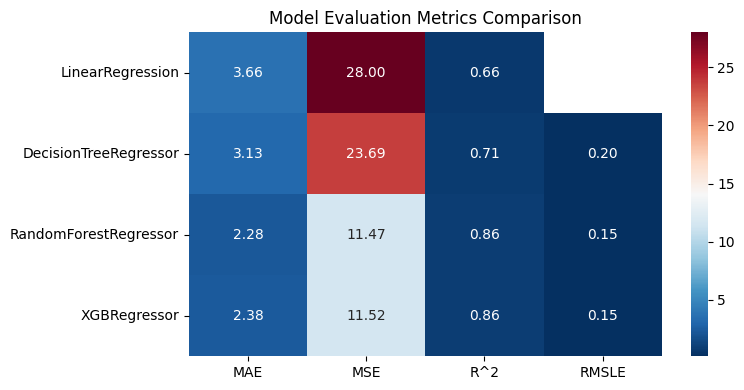

Кол-во признаков 6: ['LSTAT' 'RM' 'NOX' 'INDUS' 'PTRATIO' 'TAX']


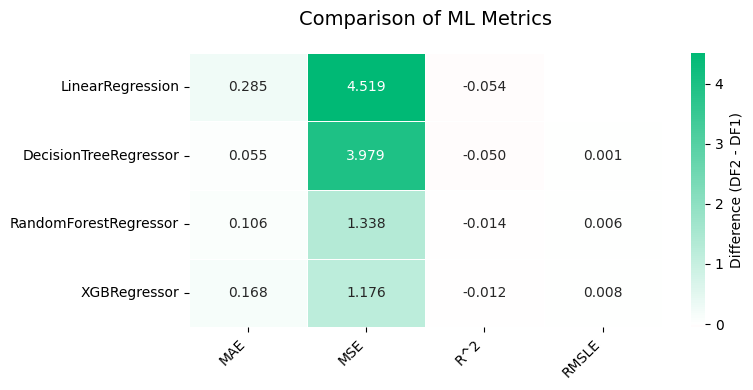

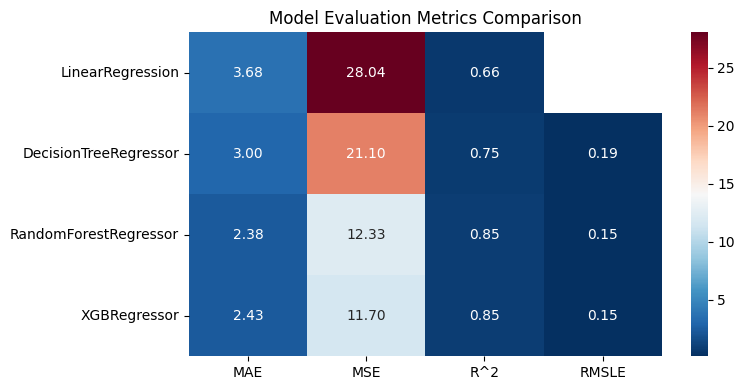

Кол-во признаков 5: ['LSTAT' 'RM' 'NOX' 'INDUS' 'PTRATIO']


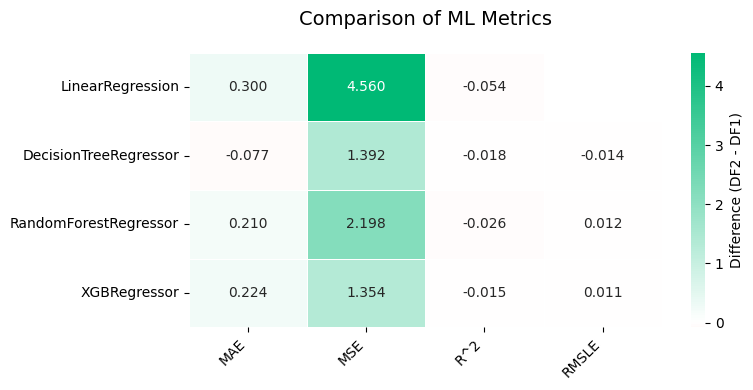

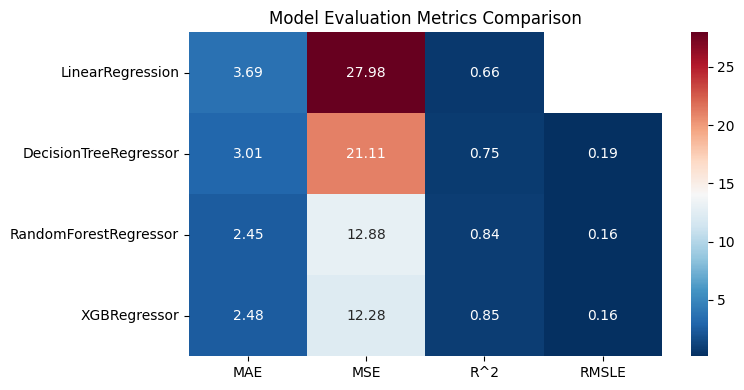

Кол-во признаков 4: ['LSTAT' 'RM' 'NOX' 'INDUS']


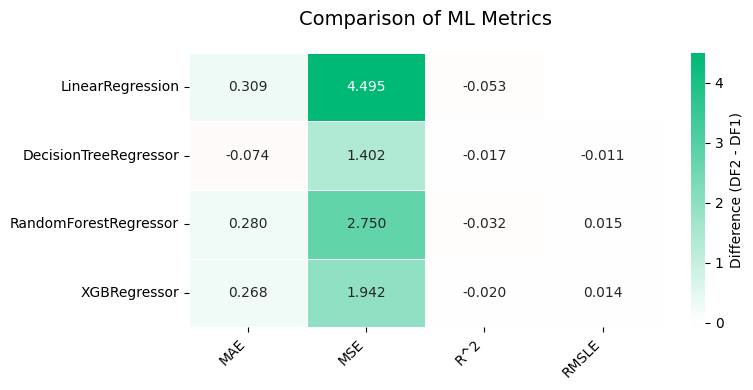

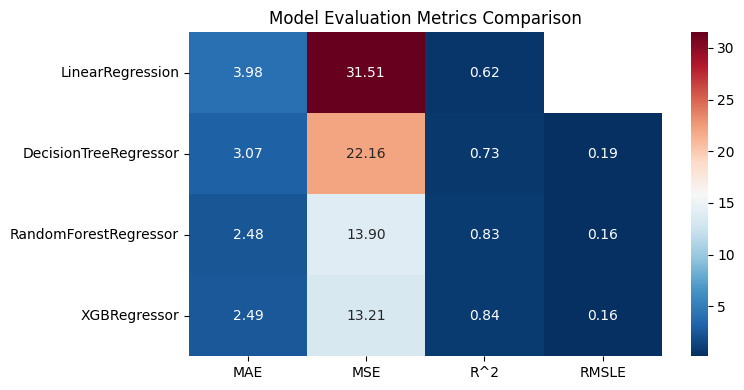

Кол-во признаков 3: ['LSTAT' 'RM' 'NOX']


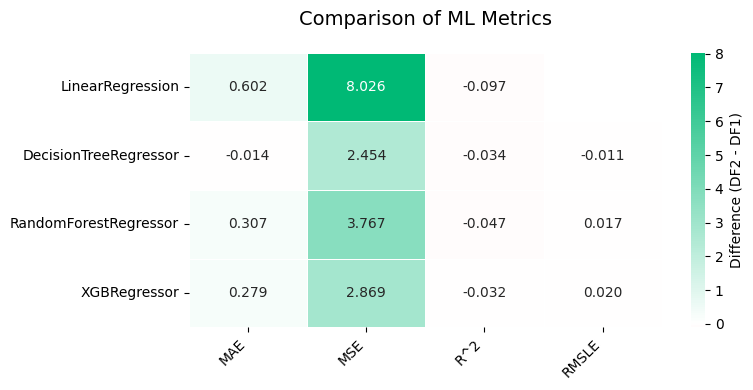

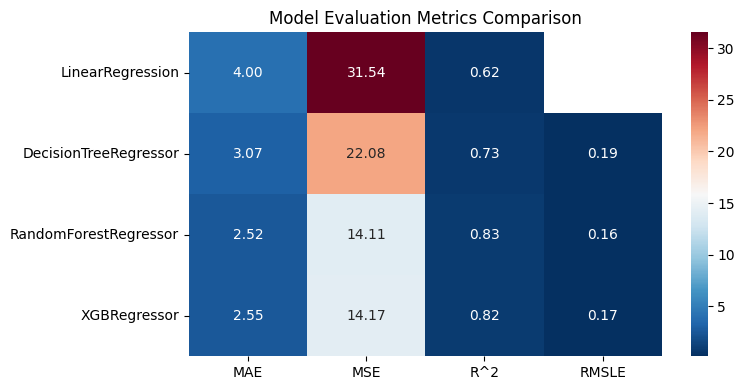

Кол-во признаков 2: ['LSTAT' 'RM']


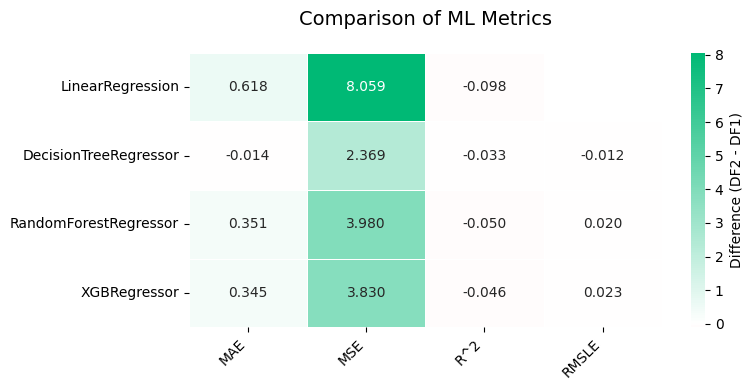

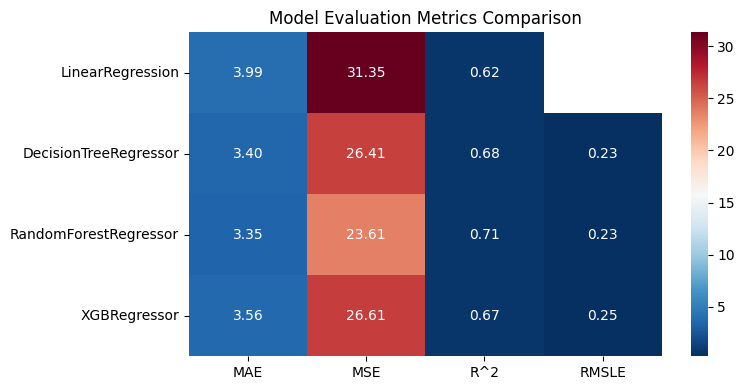

Кол-во признаков 1: ['LSTAT']


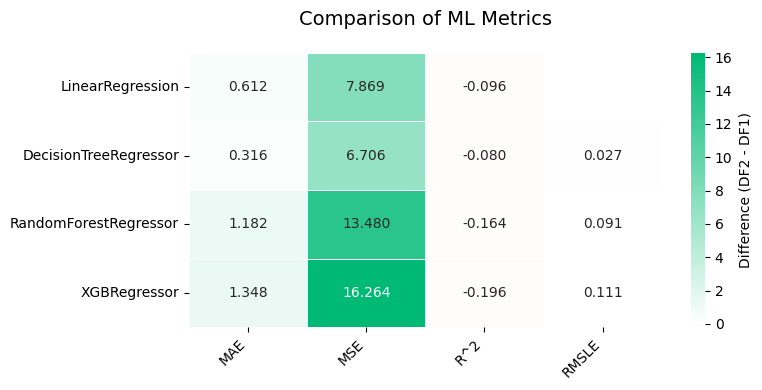

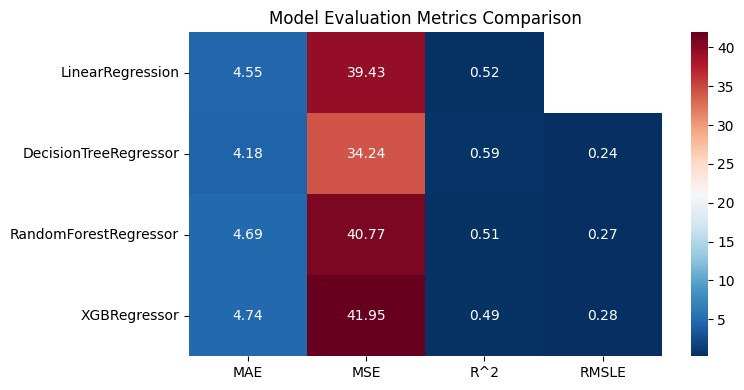

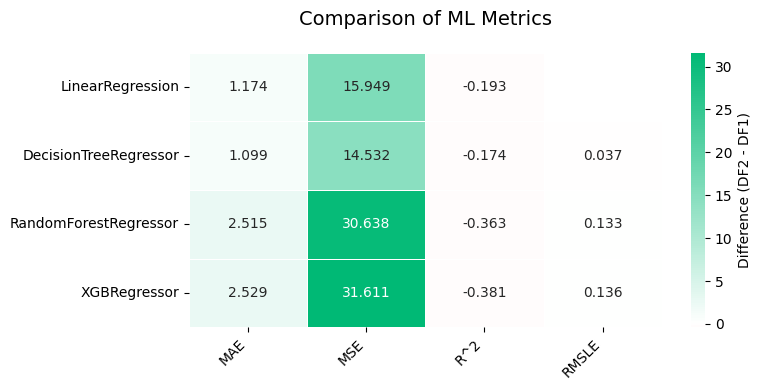

In [194]:
#Попробуем отбор с учетом нелинейности
for i in reversed(range(1,13)):
    scores = mutual_info_regression(X, y, random_state = SEED)
    
    # Toп i признаков
    top_i_idx = np.argsort(scores)[::-1][:i]
    top_i_features = X.columns[top_i_idx]
    print(f'Кол-во признаков {i}: {top_i_features.values}')
    X_selected = X[top_i_features]
    selected_metrics = train_evaluate_models_cv(
    models=models,
    X=X_selected,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED)
    compare_metrics_heatmap(initial_metrics, selected_metrics)


Как видим, существенных улучшений нет.

2.5 Стандартизация. Standard + Robust Scaler

2.5.1.1 StandardScaler без удаления

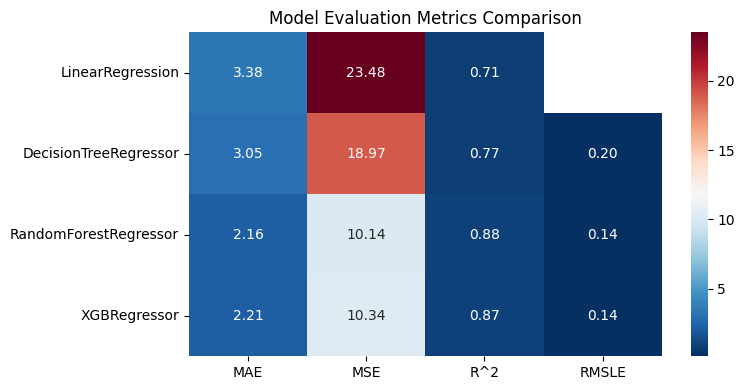

(<Figure size 800x400 with 2 Axes>,
                                 MAE           MSE           R^2     RMSLE
 LinearRegression      -4.440892e-15 -3.907985e-14  4.440892e-16       NaN
 DecisionTreeRegressor -3.177527e-02 -7.422803e-01  8.927813e-03 -0.003762
 RandomForestRegressor -1.613687e-02  9.518116e-03 -2.950678e-04 -0.000489
 XGBRegressor          -1.934186e-04 -2.061720e-03  2.194131e-05 -0.000007)

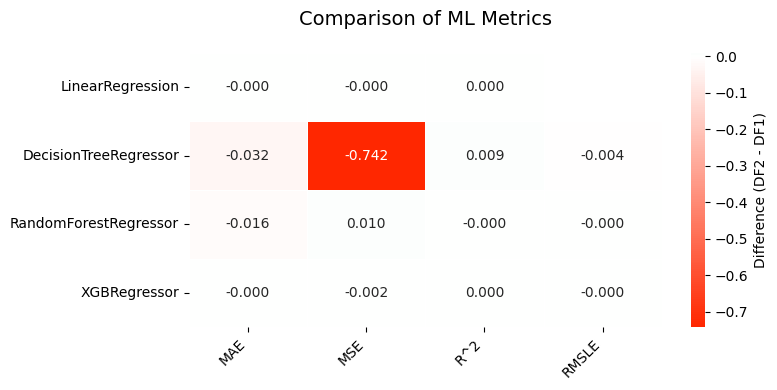

In [228]:
scaler = StandardScaler()

scaled_columns = [f'{i}_scaled' for i in X.columns.drop('CHAS')]

preprocessor_standard_scaler = ColumnTransformer(
    transformers=[
        ('scaler', scaler, scaled_columns)
    ],
    remainder='passthrough'  # остальные колонки пройдут без изменений
)
X_standard_scaler = X.copy()
X_standard_scaler[scaled_columns] = X_standard_scaler[X.columns.drop('CHAS')]
standard_scaler_metrics = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler,
    y=y,
    preprocessor=preprocessor_standard_scaler,
    cv=cv,
    seed=SEED
)
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics)

Улучшения нет вообще.

2.5.1.1 StandardScaler с удалением

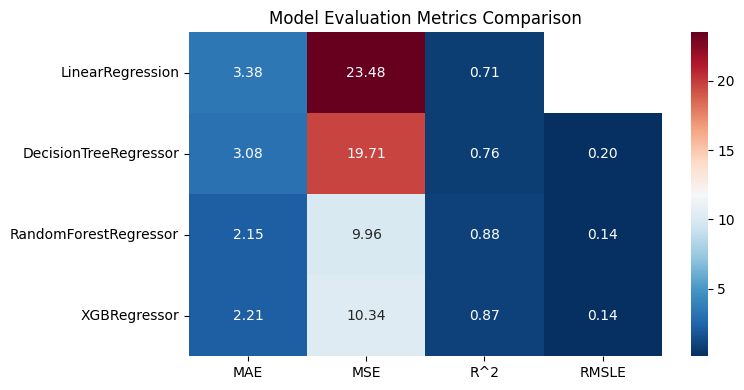

(<Figure size 800x400 with 2 Axes>,
                                 MAE           MSE           R^2     RMSLE
 LinearRegression       0.000000e+00 -1.421085e-14  0.000000e+00       NaN
 DecisionTreeRegressor -4.440892e-16  0.000000e+00  1.110223e-16  0.000000
 RandomForestRegressor -1.848150e-02 -1.727017e-01  1.705955e-03 -0.000858
 XGBRegressor          -1.934186e-04 -2.061720e-03  2.194131e-05 -0.000007)

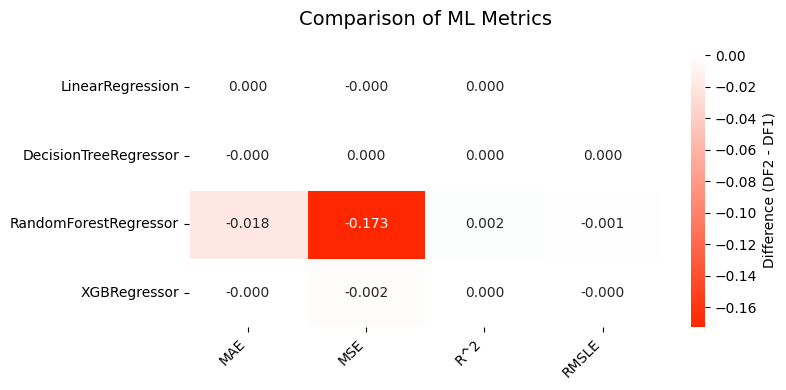

In [237]:
scaler = StandardScaler()

scaled_columns = X.columns.drop('CHAS')

preprocessor_standard_scaler = ColumnTransformer(
    transformers=[
        ('scaler', scaler, scaled_columns)
    ],
    remainder='passthrough'  # остальные колонки пройдут без изменений
)
X_standard_scaler_del = X.copy()
standard_scaler_del_metrics = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler_del,
    y=y,
    preprocessor=preprocessor_standard_scaler,
    cv=cv,
    seed=SEED
)
compare_metrics_heatmap(initial_metrics, standard_scaler_del_metrics)

Небольшое улучшение для RandomForest

2.5.2.1 RobustScaler без удаления

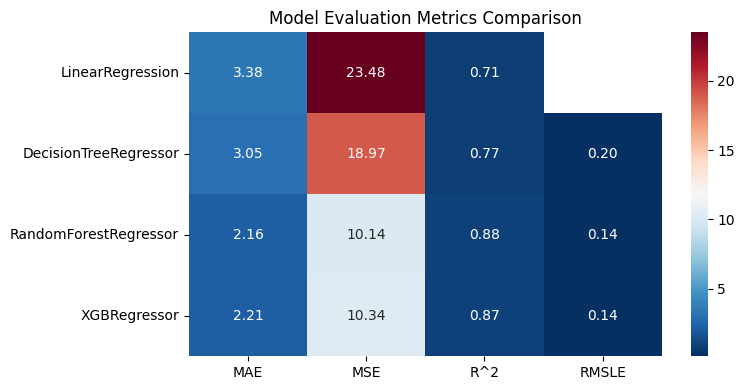

In [235]:
scaler = RobustScaler()

scaled_columns = [f'{i}_scaled' for i in X.columns.drop('CHAS')]

preprocessor_robust_scaler = ColumnTransformer(
transformers=[
('scaler', scaler, scaled_columns)
],
remainder='passthrough' # остальные колонки пройдут без изменений
)
X_robust_scaler = X.copy()
X_robust_scaler[scaled_columns] = X_robust_scaler[X.columns.drop('CHAS')]
robust_scaler_metrics = train_evaluate_models_cv(
models=models,
X=X_robust_scaler,
y=y,
preprocessor=preprocessor_robust_scaler,
cv=cv,
seed=SEED)


(<Figure size 800x400 with 2 Axes>,
                                 MAE           MSE           R^2     RMSLE
 LinearRegression      -4.440892e-15 -3.197442e-14  2.220446e-16       NaN
 DecisionTreeRegressor -1.244383e-02 -1.844974e-01  2.011313e-03  0.001808
 RandomForestRegressor -1.945017e-02 -8.562055e-02  1.134265e-03 -0.000512
 XGBRegressor          -1.934186e-04 -2.061720e-03  2.194131e-05 -0.000007)

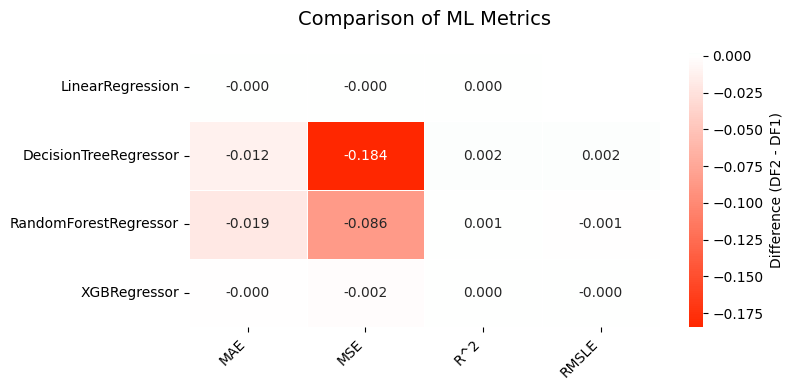

In [ ]:
compare_metrics_heatmap(initial_metrics, robust_scaler_metrics)

Тоже нет заметных улучшений.

2.5.2.2 RobustScaler с удалением

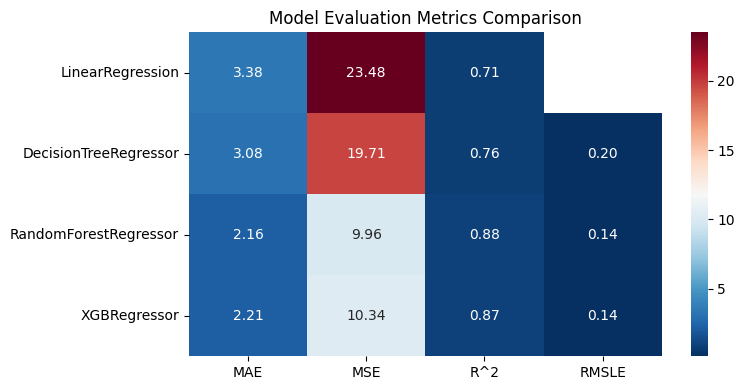

(<Figure size 800x400 with 2 Axes>,
                                 MAE           MSE           R^2     RMSLE
 LinearRegression      -2.220446e-15 -3.197442e-14  3.330669e-16       NaN
 DecisionTreeRegressor -4.440892e-16  0.000000e+00  1.110223e-16  0.000000
 RandomForestRegressor -1.505075e-02 -1.691312e-01  1.670094e-03 -0.000854
 XGBRegressor          -1.934186e-04 -2.061720e-03  2.194131e-05 -0.000007)

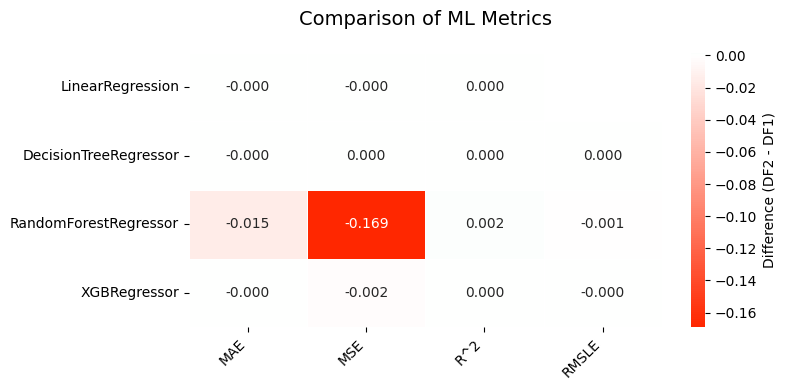

In [239]:
scaler = RobustScaler()

scaled_columns = X.columns.drop('CHAS')

preprocessor_robust_scaler = ColumnTransformer(
transformers=[
('scaler', scaler, scaled_columns)
],
remainder='passthrough' # остальные колонки пройдут без изменений
)
X_robust_scaler_del = X.copy()
robust_scaler_del_metrics = train_evaluate_models_cv(
models=models,
X=X_robust_scaler_del,
y=y,
preprocessor=preprocessor_robust_scaler,
cv=cv,
seed=SEED
)
compare_metrics_heatmap(initial_metrics, robust_scaler_del_metrics)

Небольшое улучшение для случайного леса.

2.6.1 Биннинг для признаков с мультимодальностью и тяжелыми хвостами

In [332]:
#0 огромная категория, разделим на него и две равных категории
preprocessor = Pipeline([
    ('identity', FunctionTransformer())
])
preprocessor.set_output(transform="pandas")
X_binning = X.copy()

bins = [-np.inf, 5, 30, np.inf]
labels = [0, 1, 2]

X_binning['ZN_bins'] = pd.cut(X_binning['ZN'], bins=bins, labels=labels).astype('int')
X_binning['ZN_bins'].value_counts()

ZN_bins
0    372
2     68
1     66
Name: count, dtype: int64

In [333]:
#Устраним разрыв между 500 и 700
bins = [-np.inf, 300, 500, np.inf]
labels = [0, 1, 2]

X_binning['TAX_bins'] = pd.cut(X_binning['TAX'], bins=bins, labels=labels).astype('int')
X_binning['TAX_bins'].value_counts()

TAX_bins
1    197
0    172
2    137
Name: count, dtype: int64

In [334]:
#Разделим на примерно равные группы, устранив огромный хвост в начале
bins = [-np.inf, 380, 395, np.inf]
labels = [0, 1, 2]

X_binning['B_bins'] = pd.cut(X_binning['B'], bins=bins, labels=labels).astype('int')
X_binning['B_bins'].value_counts()

B_bins
1    183
2    167
0    156
Name: count, dtype: int64

In [335]:
#Разделим на примерно равные группы, устранив огромный хвост в начале
bins = [-np.inf, 0.1, 3, np.inf]
labels = [0, 1, 2]

X_binning['CRIM_bins'] = pd.cut(X_binning['CRIM'], bins=bins, labels=labels).astype('int')
X_binning['CRIM_bins'].value_counts()

CRIM_bins
1    220
0    153
2    133
Name: count, dtype: int64

In [336]:
X_binning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    int64  
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    int64  
 9   TAX        506 non-null    float64
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  ZN_bins    506 non-null    int64  
 14  TAX_bins   506 non-null    int64  
 15  B_bins     506 non-null    int64  
 16  CRIM_bins  506 non-null    int64  
dtypes: float64(11), int64(6)
memory usage: 67.3 KB


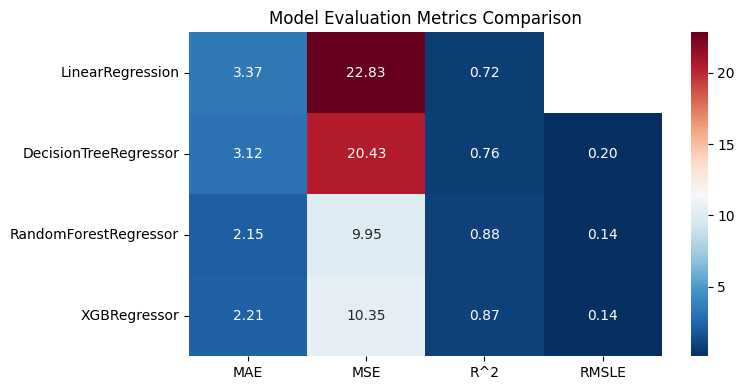

(<Figure size 800x400 with 2 Axes>,
                             MAE       MSE       R^2     RMSLE
 LinearRegression      -0.008357 -0.654278  0.008471       NaN
 DecisionTreeRegressor  0.038218  0.723901 -0.006021 -0.000358
 RandomForestRegressor -0.018112 -0.179876  0.002079 -0.000675
 XGBRegressor          -0.001093  0.005085 -0.000053 -0.000020)

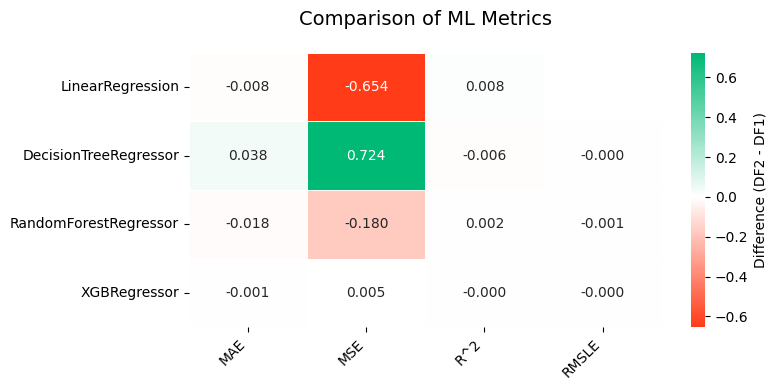

In [337]:
X_bins_metrics = train_evaluate_models_cv(
models=models,
X=X_binning,
y=y,
preprocessor=preprocessor,
cv=cv,
seed=SEED)

compare_metrics_heatmap(initial_metrics, X_bins_metrics)

Нет заметных улучшений.

2.6.2 Бининг с удалением колонок.

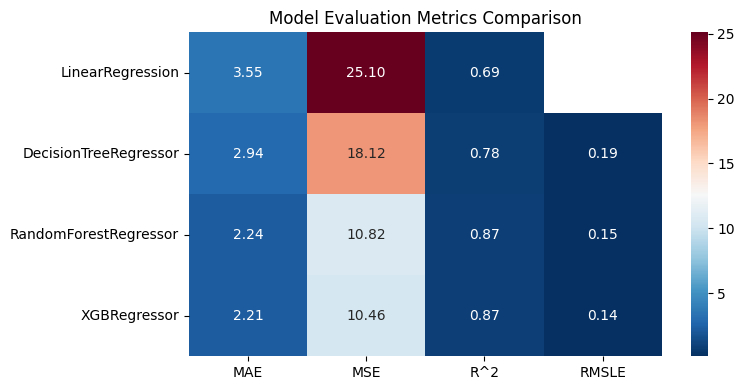

(<Figure size 800x400 with 2 Axes>,
                             MAE       MSE       R^2     RMSLE
 LinearRegression       0.168561  1.619449 -0.020175       NaN
 DecisionTreeRegressor -0.135387 -1.585416  0.020715 -0.017564
 RandomForestRegressor  0.062249  0.681998 -0.007412  0.007024
 XGBRegressor           0.000383  0.118613  0.000908  0.000806)

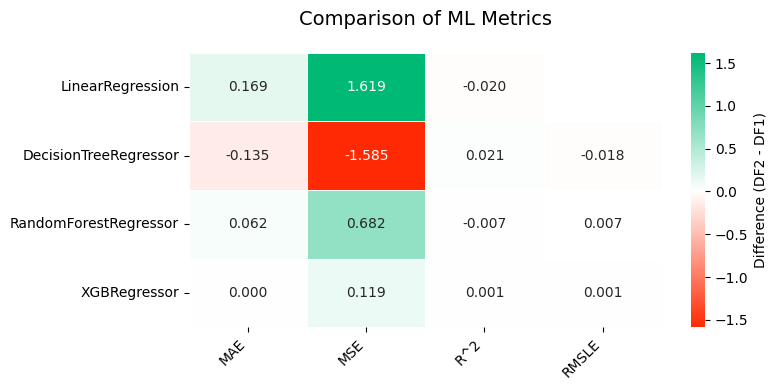

In [338]:
X_binning_del = X_binning.drop(columns = ['TAX', 'ZN', 'B', 'CRIM'])

X_bins_del_metrics = train_evaluate_models_cv(
models=models,
X=X_binning_del,
y=y,
preprocessor=preprocessor,
cv=cv,
seed=SEED)

compare_metrics_heatmap(initial_metrics, X_bins_del_metrics)


Удивительно, но стало даже хуже.

2.7 Борьба с мультиколлинеарностью -- удалим признаки с подозрительным VIF

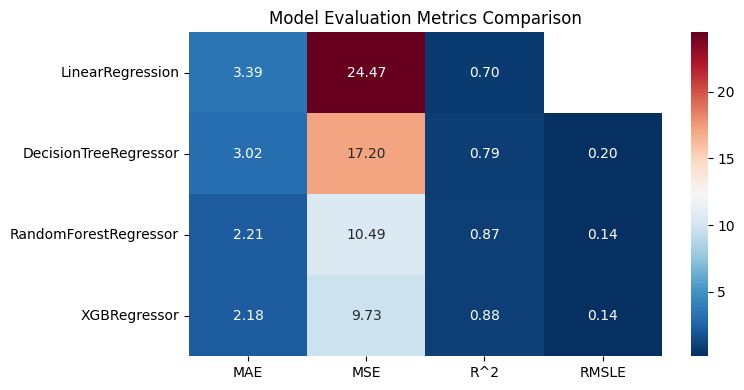

(<Figure size 800x400 with 2 Axes>,
                             MAE       MSE       R^2     RMSLE
 LinearRegression       0.013298  0.991936 -0.012558       NaN
 DecisionTreeRegressor -0.064449 -2.511449  0.024448 -0.006145
 RandomForestRegressor  0.033342  0.355433 -0.004740  0.001600
 XGBRegressor          -0.031509 -0.607277  0.006652 -0.002064)

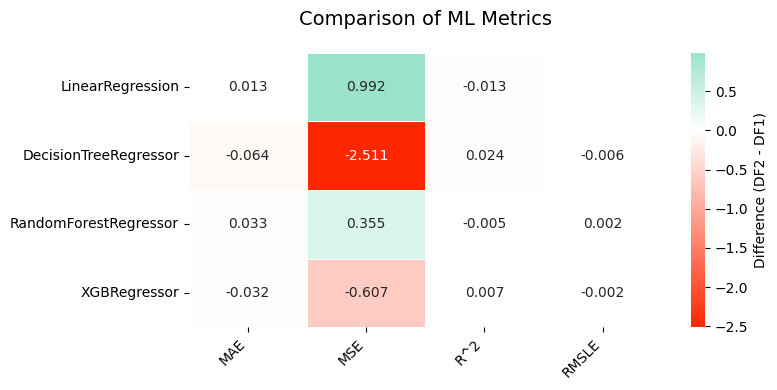

In [368]:
X_no_vif = X.copy().drop(columns = ['TAX', 'RAD'])

# X_h = X_h.drop(columns = X.columns)
X_no_vif_metrics = train_evaluate_models_cv(
models=models,
X=X_no_vif,
y=y,
preprocessor=preprocessor,
cv=cv,
seed=SEED)

compare_metrics_heatmap(initial_metrics, X_no_vif_metrics)

Очень неопределенный эффект, но для бустинга положительный

Как итог, будем использовать только PolyFeatures.